## Import Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from keras import regularizers
from tensorflow.keras.applications import  MobileNetV2
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping

### Mount Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzip the dataset from drive

In [5]:
!unzip "/content/drive/MyDrive/Edge AI Fall detection/Roboflow/Dataset.zip" -d "/content/Edge AI Fall detection/"


Streaming output truncated to the last 5000 lines.
  inflating: /content/Edge AI Fall detection/Unwanted Removed/labels/val/fall23289.txt  
  inflating: /content/Edge AI Fall detection/__MACOSX/Unwanted Removed/labels/val/._fall23289.txt  
  inflating: /content/Edge AI Fall detection/Unwanted Removed/labels/val/fall22197.txt  
  inflating: /content/Edge AI Fall detection/__MACOSX/Unwanted Removed/labels/val/._fall22197.txt  
  inflating: /content/Edge AI Fall detection/Unwanted Removed/labels/val/20230923_200054_jpg.rf.7fe2592b291a8b20b6a1f6a7b9bc7b53.txt  
  inflating: /content/Edge AI Fall detection/Unwanted Removed/labels/val/non-fall10538.txt  
  inflating: /content/Edge AI Fall detection/__MACOSX/Unwanted Removed/labels/val/._non-fall10538.txt  
  inflating: /content/Edge AI Fall detection/Unwanted Removed/labels/val/fall20958.txt  
  inflating: /content/Edge AI Fall detection/__MACOSX/Unwanted Removed/labels/val/._fall20958.txt  
  inflating: /content/Edge AI Fall detection/Unwan

## Define Base Directory and Data Generator

In [ ]:
BASE_DIR = "/content/Edge AI Fall detection/content/Edge AI Fall detection/Unwanted Removed/"

def data_generator(split='train', pref_size=(128, 128), batch_size=32):
    """
    Generator that yields batches of cropped images and class labels.

    Assumes folder structure:
      BASE_DIR/images/<split>/
      BASE_DIR/labels/<split>/

    For each image file, the generator reads the corresponding label file.
    For simplicity, it processes only the first bounding box per file.
    """
    img_dir = os.path.join(BASE_DIR, 'images', split)
    label_dir = os.path.join(BASE_DIR, 'labels', split)

    img_files = sorted(os.listdir(img_dir))
    label_files = sorted(os.listdir(label_dir))

    num_samples = len(img_files)

    while True:
        # Shuffle indices at the beginning of each epoch
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for offset in range(0, num_samples, batch_size):
            batch_imgs = []
            batch_labels = []
            batch_indices = indices[offset:offset+batch_size]

            for idx in batch_indices:
                img_file = img_files[idx]
                label_file = label_files[idx]

                # Read the image and convert from BGR to RGB
                img_path = os.path.join(img_dir, img_file)
                img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
                image_height, image_width, _ = img.shape

                label_path = os.path.join(label_dir, label_file)
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                if len(lines) == 0:
                    continue

                # Process only the first bounding box in the file
                line = lines[0]
                parts = line.split()
                if len(parts) < 5:
                    print(f"Warning: {label_file} does not have enough values: {line}")
                    continue
                class_label = int(parts[0])
                if len(parts) == 5:
                    # Standard YOLO format: <class> <x_center> <y_center> <width> <height>
                    x_center, y_center, width, height = map(float, parts[1:5])
                    xmin = int(x_center * image_width - (width * image_width) / 2)
                    ymin = int(y_center * image_height - (height * image_height) / 2)
                    crop_width = int(width * image_width)
                    crop_height = int(height * image_height)
                else:
                    # Extended format: <class> followed by multiple normalized coordinate pairs.
                    # Compute bounding box by taking the min and max of the coordinates.
                    coords = list(map(float, parts[1:]))
                    xs = [x * image_width for x in coords[0::2]]
                    ys = [y * image_height for y in coords[1::2]]
                    xmin, ymin = int(min(xs)), int(min(ys))
                    xmax, ymax = int(max(xs)), int(max(ys))
                    crop_width, crop_height = xmax - xmin, ymax - ymin

                # Ensure the crop indices are within image boundaries
                x_start, y_start = max(0, xmin), max(0, ymin)
                x_end, y_end = min(image_width, xmin + crop_width), min(image_height, ymin + crop_height)

                # Crop the image
                cropped = img[y_start:y_end, x_start:x_end]
                if cropped.size == 0:
                    print(f"Warning: empty crop for {img_file} with box {line}")
                    continue
                try:
                    # Resize crop to the preferred size
                    cropped_resized = cv2.resize(cropped, pref_size)
                except Exception as e:
                    print(f"Error resizing image {img_file}: {e}")
                    continue

                batch_imgs.append(cropped_resized)
                batch_labels.append(class_label)

            if batch_imgs:
                X_batch = np.array(batch_imgs, dtype=np.float32) / 255.0
                y_batch = np.array(batch_labels)
                yield X_batch, y_batch

## Create Dataset objects and Calculate Steps

In [ ]:
def count_samples(split='train'):
    img_dir = os.path.join(BASE_DIR, 'images', split)
    return len(os.listdir(img_dir))

BATCH_SIZE = 32
train_samples = count_samples('train')
val_samples   = count_samples('val')
test_samples  = count_samples('test')

steps_per_epoch = int(np.ceil(train_samples / BATCH_SIZE))
val_steps       = int(np.ceil(val_samples / BATCH_SIZE))
test_steps      = int(np.ceil(test_samples / BATCH_SIZE))

print(f"Train samples: {train_samples}, Steps per epoch: {steps_per_epoch}")
print(f"Validation samples: {val_samples}, Validation steps: {val_steps}")
print(f"Test samples: {test_samples}, Test steps: {test_steps}")


Train samples: 23756, Steps per epoch: 743
Validation samples: 6638, Validation steps: 208
Test samples: 3340, Test steps: 105


## Create Dataset objects from the generator for each split

In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator('train', batch_size=BATCH_SIZE),
    output_types=(tf.float32, tf.int32),
    output_shapes=([None, 128, 128, 3], [None])
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator('val', batch_size=BATCH_SIZE),
    output_types=(tf.float32, tf.int32),
    output_shapes=([None, 128, 128, 3], [None])
).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator('test', batch_size=BATCH_SIZE),
    output_types=(tf.float32, tf.int32),
    output_shapes=([None, 128, 128, 3], [None])
).prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


## Build and Train the Model

In [ ]:
# Load the MobileNetV2 base model with ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers first, then unfreeze the last 20 layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# Set up early stopping callback to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 1,370,306 (5.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

## Train the model

In [ ]:
history = model.fit(
    train_dataset,
    epochs=25,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=[early_stop]
)

Epoch 1/25
743/743 ━━━━━━━━━━━━━━━━━━━━ 683s 903ms/step - accuracy: 0.7017 - loss: 0.8249 - val_accuracy: 0.8499 - val_loss: 0.5813
Epoch 2/25
743/743 ━━━━━━━━━━━━━━━━━━━━ 683s 920ms/step - accuracy: 0.8868 - loss: 0.5090 - val_accuracy: 0.9064 - val_loss: 0.4587
Epoch 3/25
743/743 ━━━━━━━━━━━━━━━━━━━━ 683s 919ms/step - accuracy: 0.9205 - loss: 0.4340 - val_accuracy: 0.9308 - val_loss: 0.4063
Epoch 4/25
743/743 ━━━━━━━━━━━━━━━━━━━━ 665s 895ms/step - accuracy: 0.9369 - loss: 0.3929 - val_accuracy: 0.9436 - val_loss: 0.3719
Epoch 5/25
743/743 ━━━━━━━━━━━━━━━━━━━━ 684s 921ms/step - accuracy: 0.9485 - loss: 0.3594 - val_accuracy: 0.9509 - val_loss: 0.3505
Epoch 6/25
743/743 ━━━━━━━━━━━━━━━━━━━━ 680s 915ms/step - accuracy: 0.9567 - loss: 0.3385 - val_accuracy: 0.9560 - val_loss: 0.3378
Epoch 7/25
743/743 ━━━━━━━━━━━━━━━━━━━━ 677s 912ms/step - accuracy: 0.9614 - loss: 0.3216 - val_accuracy: 0.9592 - val_loss: 0.3273
Epoch 8/25
743/743 ━━━━━━━━━━━━━━━━━━━━ 665s 895ms/step - accuracy: 0.9661 -

### Plot Training History

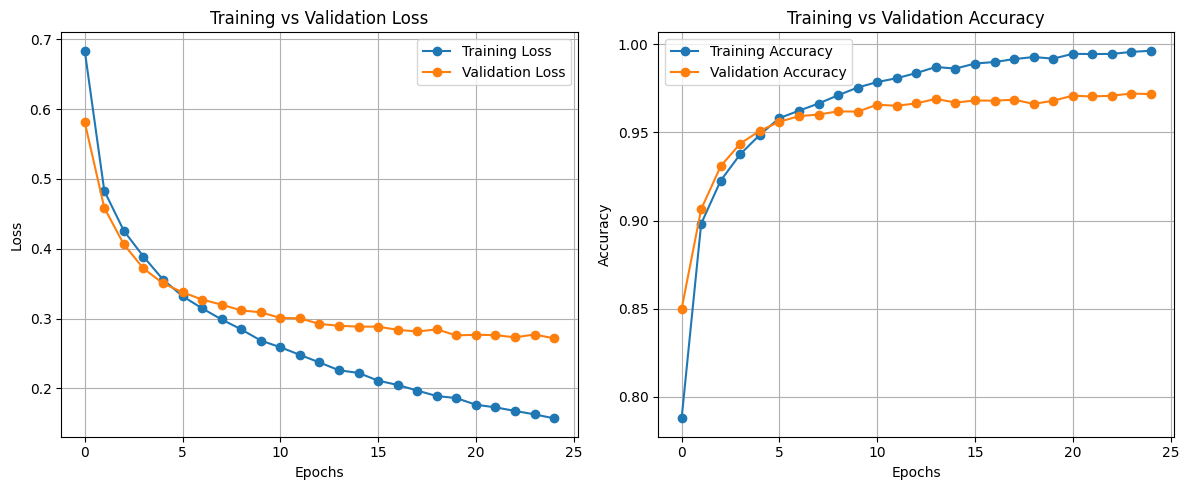

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss", marker='o')
plt.plot(val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Training Accuracy", marker='o')
plt.plot(val_acc, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Save the Model

In [ ]:
model.save('/content/drive/MyDrive/Edge AI Fall detection/Roboflow/Fall-Detector.h5')

### Evaluate the Model on the Test Set

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=test_steps)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

105/105 ━━━━━━━━━━━━━━━━━━━━ 54s 481ms/step - accuracy: 0.9615 - loss: 0.3058
Test Loss: 0.2929, Test Accuracy: 0.9659


### Load the model

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Edge AI Fall detection/Roboflow/Fall-Detector.h5')

## Convert the Model to a Fully Quantized TFLite Model

In [ ]:
def representative_dataset():
    image_size = (128, 128)
    samples = []

    # Take one batch from the test dataset for calibration
    for X_batch, _ in test_dataset.take(1):
        for i in range(min(250, X_batch.shape[0])):
            # Convert the tensor to a numpy array and add a batch dimension
            sample = np.expand_dims(X_batch[i].numpy(), axis=0)
            samples.append(sample)
    for sample in samples:
        yield [sample]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Set the optimization flag to default; this enables quantization optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to int8 for quantized inference
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_dataset

tflite_quant_model = converter.convert()
with open("/content/drive/MyDrive/Edge AI Fall detection/Roboflow/Fall-Detector-Lite.tflite", "wb") as f:
    f.write(tflite_quant_model)

print("Fully integer quantized TFLite model saved as 'Fall-Detector-Lite.tflite'")

Saved artifact at '/tmp/tmpgd3zwzku'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137175888896144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137175888892304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137175888893264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137175888891920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137175888893072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137175888892496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137175866410384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137175866410768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137175866410576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137175866409232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1371758664119

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Fully integer quantized TFLite model saved as 'fall_detection_int8.tflite'


## Load YOLOv5 for Detection

In [ ]:
import torch

# Load YOLOv5 model for person detection
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
yolo_model.classes = [0]  # Restrict detections to person class


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-4-6 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 102MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


### Load the quantized TFLite model and allocate tensors

In [ ]:
tflite_model_path = "/content/drive/MyDrive/Edge AI Fall detection/Roboflow/Fall-Detector-Lite.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']
pref_size = (128, 128)


### Function to classify the image

In [ ]:
def classify_crop(cropped_img):
    """
    Preprocess a cropped image and run classification using the TFLite model.
    Returns the predicted class and raw output.
    """
    # Convert image from BGR to RGB
    cropped_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(cropped_rgb, pref_size)
    normalized = resized.astype(np.float32) / 255.0

    if input_scale != 0:
        quantized_input = normalized / input_scale + input_zero_point
        quantized_input = np.clip(quantized_input, -128, 127).astype(np.int8)
    else:
        quantized_input = normalized

    input_data = np.expand_dims(quantized_input, axis=0)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    if output_scale != 0:
        output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale

    predicted_class = np.argmax(output_data)
    return predicted_class, output_data

## Real-Time Fall Detection with TFLite Classifier

In [ ]:
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

print("Starting real-time fall detection. Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame. Exiting...")
        break

    # Convert frame to RGB and create a PIL image for YOLO
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(frame_rgb)
    results = yolo_model(pil_img, size=640)
    df = results.pandas().xyxy[0]
    fall_detected = False

    for idx, row in df.iterrows():
        if row['confidence'] > 0.5:
            x1 = int(row['xmin'])
            y1 = int(row['ymin'])
            x2 = int(row['xmax'])
            y2 = int(row['ymax'])
            crop = frame[y1:y2, x1:x2]
            if crop.size == 0:
                continue

            pred, raw_output = classify_crop(crop)
            print(f"Raw output: {raw_output}, Predicted class: {pred}")

            if pred == 0:
                label_text = "Fall Detected"
                fall_detected = True
            else:
                label_text = "Non-Fall"

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label_text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    if fall_detected:
        print("Fall detected in current frame!")

    cv2.imshow("Real-Time Fall Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()